In [ ]:
#importing libarys 
import re
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import math

### The parse_cdhit.py code whit some changes. For step b of the project

In [ ]:


def make_cluster_table(filename):

  clustnum_pat = re.compile("Cluster\s(\d+)$")
  member_pat = re.compile("\>(.+)\.\.\.")

  with open(filename, "r") as f:
      file = f.readlines()

      outdict = {}
      repr = {}

      for line in file:
          if "Cluster" in line:
              current_clust = re.search(clustnum_pat, line).group(0)
  #            print(current_clust)
          else:
              current_member = re.search(member_pat, line).group(1)
  #            print(current_member)
              outdict[current_member] = current_clust
          if "*" in line:
              r = line.split(">")[1].split("...")[0]
              repr[current_clust] = r

  outdf = pd.DataFrame.from_dict(outdict, orient = 'index', columns = ['cluster'])
  outdf = outdf.reset_index().rename(columns={"index": "id"})
  reprdf = pd.DataFrame.from_dict(repr, orient = 'index', columns = ['id'])
  reprdf = reprdf.reset_index().rename(columns={"index": "cluster"})
  reprdf['representative'] = True

  mer = outdf.merge(reprdf, on = ['id', 'cluster'], how = 'left')
  mer.fillna(False, inplace = True)

  mer.to_csv(filename + "_members.csv", index = False)

  freq = mer['cluster'].value_counts().to_frame()

  freq.to_csv(filename + "_cluster_sizes.csv", header = None)

#Calling the function
make_cluster_table("SS2.fasta_subsample_clusters.clstr")
make_cluster_table("SS1.fasta_subsample_clusters.clstr")

### Extract the abundant 16s sequences (step c in the project)

In [ ]:
#Readind the csv files and puting them into dataframes

df_SS1_members=pd.read_csv("SS1.fasta_subsample_clusters.clstr_members.csv")
df_SS2_members=pd.read_csv("SS2.fasta_subsample_clusters.clstr_members.csv")

def cluster_x_and_above(df,name,filter_number):
  group=df.groupby(by=['cluster'])
  group_x_and_above=group.filter(lambda x: len(x) >=filter_number)
  df_g = group_x_and_above.query('representative == True')
  df_g=df_g.filter(['id'])
  df_g.to_csv(name,sep='\t', index = False)
  

cluster_x_and_above(df_SS1_members ,'df_SS1_members.tsv',10)
cluster_x_and_above(df_SS2_members ,'df_SS2_members.tsv',10)

### Finding the corresponding OTU ID from the greengenes database 
Keeping the top hit (step f)


In [ ]:
#Readind the tsv files and puting them into dataframes
df_SS1_top_hits=pd.read_csv("SS1_top_hits.tsv", sep='\t')
df_SS2_top_hits=pd.read_csv("SS2_top_hits.tsv", sep='\t')


def putting_headers_on_blastn_defult(df):
  df.columns=['qseqid' ,'sseqid' ,'pident' ,'length' ,'mismatch' ,'gapopen' ,'qstart' ,'qend' ,'sstart' ,'send' ,'evalue' ,'bitscore']#the default values when doing blastn -outfmt 6
  return df

df_SS1_top_hits=putting_headers_on_blastn_defult(df_SS1_top_hits)
df_SS2_top_hits=putting_headers_on_blastn_defult(df_SS2_top_hits)
print(df_SS1_top_hits)

        qseqid   sseqid  pident  length  mismatch  gapopen  qstart  qend  \
0       SS1.50  1131894  95.455     242        11        0     252   493   
1       SS1.50  3359884  98.000     250         5        0       1   250   
2       SS1.50  3359884  95.455     242        11        0     252   493   
3       SS1.70   314378  98.406     251         3        1       1   251   
4       SS1.70   314378  97.788     226         4        1     277   502   
..         ...      ...     ...     ...       ...      ...     ...   ...   
335   SS1.8543   933880  95.686     255        10        1     249   502   
336   SS1.8543   151709  94.024     251        15        0       1   251   
337  SS1.12325   248218  96.813     251         8        0       1   251   
338  SS1.12325   248218  94.821     251        13        0     252   502   
339  SS1.12325  1131787  96.032     252         5        5       1   251   

     sstart  send         evalue  bitscore  
0       749   508  4.390000e-107       387

In [ ]:
def top_hit_from_blastn(df):
  idx=df.groupby(['qseqid'])['pident'].transform(max)==df['pident']
  df=df[idx]
  return df
  

df_SS2_top_hits=top_hit_from_blastn(df_SS2_top_hits)
df_SS1_top_hits=top_hit_from_blastn(df_SS1_top_hits)
print(df_SS2_top_hits)

#Taking only one 16s id in case there is the same percentage of similarity for 2 different taxonomies for the same 16s gene


def taking_only_one_16s_id(df):
  group=df.groupby(by=['qseqid'], as_index=False)
  df=group.first()
  return df
  

df_SS1_top_hits_f=taking_only_one_16s_id(df_SS1_top_hits)
df_SS2_top_hits_f=taking_only_one_16s_id(df_SS2_top_hits)


        qseqid   sseqid  pident  length  mismatch  gapopen  qstart  qend  \
1        SS2.1  1862427  98.406     251         4        0     251   501   
3        SS2.6   222209  99.194     248         2        0       1   248   
5        SS2.6   159763  99.194     248         1        1       1   248   
7       SS2.16   590297  99.203     251         2        0       1   251   
11      SS2.41   559780  97.211     251         7        0       1   251   
..         ...      ...     ...     ...       ...      ...     ...   ...   
332  SS2.15247   815189  96.016     251        10        0       1   251   
336  SS2.19618   248505  97.211     251         7        0       1   251   
338  SS2.19618   207240  97.211     251         7        0       1   251   
340  SS2.24813   314378  96.813     251         7        1       1   251   
344  SS2.37021  2420243  98.394     249         4        0       1   249   

     sstart  send         evalue  bitscore  
1       800   550  9.230000e-124       442

### Finding the taxonony of the top blast hits on the 16s ID column.
step g

In [ ]:

#Readind the txt as a tsv file and puting them into dataframes whit headers
otu_taxonomy=pd.read_csv("91_otu_taxonomy.txt", sep='\t')
otu_taxonomy.columns=['OTU ID' ,'taxonomy']

def merge_taxonomy_whit_df_whit_otu_id(otu_taxonomy,df_top_hits):
  otu_taxonomy['OTU ID']=otu_taxonomy['OTU ID'].astype(str)
  df_top_hits["sseqid"]=df_top_hits["sseqid"].astype(str)
  df=df_top_hits.merge(otu_taxonomy,left_on="sseqid",right_on="OTU ID",how="left")
  #removing the unnecessary columns
  df=df.drop(["OTU ID","pident","length","mismatch","gapopen","qstart","qend","sstart","send","evalue","bitscore"], axis=1)
  return df

df_SS1_top_hits_whit_taxonomy=merge_taxonomy_whit_df_whit_otu_id(otu_taxonomy,df_SS1_top_hits_f)
df_SS2_top_hits_whit_taxonomy=merge_taxonomy_whit_df_whit_otu_id(otu_taxonomy,df_SS2_top_hits_f)
print(df_SS2_top_hits_whit_taxonomy)





        qseqid   sseqid                                           taxonomy
0        SS2.1  1862427  k__Bacteria; p__Proteobacteria; c__Gammaproteo...
1    SS2.10014   155640  k__Bacteria; p__Proteobacteria; c__Alphaproteo...
2     SS2.1024    20428  k__Bacteria; p__Bacteroidetes; c__Sphingobacte...
3      SS2.108  2152194  k__Bacteria; p__Proteobacteria; c__Alphaproteo...
4     SS2.1118  1145138  k__Bacteria; p__Proteobacteria; c__Betaproteob...
..         ...      ...                                                ...
98      SS2.92   237121  k__Bacteria; p__Verrucomicrobia; c__Opitutae; ...
99     SS2.942  1115104  k__Bacteria; p__Proteobacteria; c__Gammaproteo...
100     SS2.95   244531  k__Bacteria; p__Proteobacteria; c__Alphaproteo...
101   SS2.9877  1142061  k__Bacteria; p__Proteobacteria; c__Alphaproteo...
102    SS2.991    81668  k__Bacteria; p__Bacteroidetes; c__Sphingobacte...

[103 rows x 3 columns]


### Arranging the data frame 
step h

In [ ]:


def areange_the_dataframe(df):
  taxonomy=["kingdom","phylum","class","order","family","genus","species"]
  df[taxonomy] = df['taxonomy'].str.split(';', expand=True)
  for tax in taxonomy:
    df[tax] = df[tax].str.split('_').str[-1]
    #reaplacing the blank str whit nan
    df[taxonomy]=df[taxonomy].replace(r'^\s*$', np.nan, regex=True)
  df=df.drop(["taxonomy"], axis=1)
  return df

df_SS1_top_hits_whit_taxonomy=areange_the_dataframe(df_SS1_top_hits_whit_taxonomy)
df_SS2_top_hits_whit_taxonomy=areange_the_dataframe(df_SS2_top_hits_whit_taxonomy)

###  Connection between the id of your representative and which cd-hit cluster it is in
Step i

In [ ]:
ss1_clstr_members=pd.read_csv("SS1.fasta_subsample_clusters.clstr_members.csv")
ss2_clstr_members=pd.read_csv("SS2.fasta_subsample_clusters.clstr_members.csv")

      
def merge_clstr_members_whit_toxonomy(df_top_hits_whit_taxonomy,df_clstr_members):
  df=df_clstr_members.merge(df_top_hits_whit_taxonomy,left_on="id",right_on="qseqid",how="right")
  df_only_relevent_col=df[["qseqid","cluster","sseqid","kingdom","phylum","class","order","family","genus","species"]]
  return df_only_relevent_col


df_SS1_clstr_members_whit_taxonomy=merge_clstr_members_whit_toxonomy(df_SS1_top_hits_whit_taxonomy,ss1_clstr_members)
df_SS2_clstr_members_whit_taxonomy=merge_clstr_members_whit_toxonomy(df_SS2_top_hits_whit_taxonomy,ss2_clstr_members)


print(df_SS1_clstr_members_whit_taxonomy)


      qseqid     cluster   sseqid   kingdom          phylum  \
0   SS1.1013  Cluster 41   831289  Bacteria  Actinobacteria   
1   SS1.1025  Cluster 18   550392  Bacteria   Bacteroidetes   
2   SS1.1052  Cluster 40   252540  Bacteria     Chloroflexi   
3    SS1.108   Cluster 9    33590  Bacteria  Proteobacteria   
4    SS1.113   Cluster 6  1131894  Bacteria   Cyanobacteria   
..       ...         ...      ...       ...             ...   
93   SS1.870  Cluster 54    84386  Bacteria  Proteobacteria   
94   SS1.889  Cluster 42  3100155  Bacteria  Proteobacteria   
95   SS1.916  Cluster 37    90390  Bacteria  Proteobacteria   
96   SS1.942  Cluster 66   725727  Bacteria   Bacteroidetes   
97   SS1.989  Cluster 33  3469751  Bacteria  Proteobacteria   

                  class               order            family       genus  \
0         Rubrobacteria     Rubrobacterales  Rubrobacteraceae         NaN   
1      Sphingobacteriia  Sphingobacteriales  Chitinophagaceae         NaN   
2          A

### Linking the taxa to the cluster size
step j



In [ ]:

#Read the files so that the first line is not the column headers. Then insertion of appropriate headings
ss1_clstr_sizes=pd.read_csv("SS1.fasta_subsample_clusters.clstr_cluster_sizes.csv", header=None)
ss1_clstr_sizes.columns=['cluster' ,'size']
ss2_clstr_sizes=pd.read_csv("SS2.fasta_subsample_clusters.clstr_cluster_sizes.csv", header=None)
ss2_clstr_sizes.columns=['cluster' ,'size']

def merge_clstr_size_whit_df_toxonomy_and_members(df_clstr_members_whit_taxonomy,df_clstr_sizes):
  df=pd.merge(df_clstr_members_whit_taxonomy, df_clstr_sizes,on=["cluster"],how="left")
  #Beautify the created data frame
  second_column = df.pop('sseqid')
  forth_column = df.pop('size') 
  df.insert(1, 'sseqid', second_column )
  df.insert(3, 'size', forth_column )
  df=df.sort_values("cluster")
  df=df.reset_index(drop=True)
  return df
df_SS1_clstr_members_whit_taxonomy_and_size=merge_clstr_size_whit_df_toxonomy_and_members(df_SS1_clstr_members_whit_taxonomy,ss1_clstr_sizes)
df_SS2_clstr_members_whit_taxonomy_and_size=merge_clstr_size_whit_df_toxonomy_and_members(df_SS2_clstr_members_whit_taxonomy,ss2_clstr_sizes) 
print(df_SS1_clstr_members_whit_taxonomy_and_size)



       qseqid   sseqid      cluster  size   kingdom          phylum  \
0    SS1.6467  2420243    Cluster 0   750  Bacteria  Proteobacteria   
1      SS1.50  3359884    Cluster 1   385  Bacteria   Cyanobacteria   
2     SS1.801   204984   Cluster 10   119  Bacteria  Proteobacteria   
3    SS1.1517  3469751  Cluster 100    11  Bacteria  Proteobacteria   
4    SS1.4084  1126808  Cluster 101    11  Bacteria     Nitrospirae   
..        ...      ...          ...   ...       ...             ...   
93  SS1.12325   248218   Cluster 95    12  Bacteria   Fibrobacteres   
94   SS1.3659   336745   Cluster 96    12  Bacteria  Proteobacteria   
95   SS1.3410   811187   Cluster 97    12  Bacteria   Acidobacteria   
96   SS1.4229   114170   Cluster 98    12  Bacteria  Proteobacteria   
97   SS1.6849   786030   Cluster 99    11  Bacteria  Proteobacteria   

                  class             order             family       genus  \
0   Alphaproteobacteria     Rickettsiales       mitochondria         Na

### Grouping by phylum and calculating the sum of the cluster sizes per phylum or class.
step k

In [ ]:
def calculating_the_sum_of_cluster_size_per_taxonomy_level(df,taxonomy_level):
  group=df.groupby([taxonomy_level], as_index=False, dropna=False)
  df= group["size"].sum()
  return df

df_SS1_sum_size_by_phylum=calculating_the_sum_of_cluster_size_per_taxonomy_level(df_SS1_clstr_members_whit_taxonomy_and_size,"phylum") 
print("The sum of the clusters size according to phylum in SS1 is :")
print(df_SS1_sum_size_by_phylum) 
print("--------------------------------------------------------------------------") 
df_SS1_sum_size_by_class=calculating_the_sum_of_cluster_size_per_taxonomy_level(df_SS1_clstr_members_whit_taxonomy_and_size,"class") 
print("The sum of the clusters size according to class in SS1 is :")
print(df_SS1_sum_size_by_class)
print("--------------------------------------------------------------------------") 

df_SS2_sum_size_by_phylum=calculating_the_sum_of_cluster_size_per_taxonomy_level(df_SS2_clstr_members_whit_taxonomy_and_size,"phylum") 
print("The sum of the clusters size according to phylum in SS2 is :")
print(df_SS2_sum_size_by_phylum)
print("--------------------------------------------------------------------------")  
df_SS2_sum_size_by_class=calculating_the_sum_of_cluster_size_per_taxonomy_level(df_SS2_clstr_members_whit_taxonomy_and_size,"class") 
print("The sum of the clusters size according to class in SS2 is :")
print(df_SS2_sum_size_by_class) 
print("--------------------------------------------------------------------------") 




The sum of the clusters size according to phylum in SS1 is :
              phylum  size
0      Acidobacteria    94
1     Actinobacteria   460
2      Bacteroidetes   352
3        Chloroflexi    59
4      Crenarchaeota    14
5      Cyanobacteria   548
6      Fibrobacteres    12
7         Firmicutes   105
8   Gemmatimonadetes    16
9        Nitrospirae    11
10    Planctomycetes    29
11    Proteobacteria  3408
12      Spirochaetes    31
13   Verrucomicrobia    56
--------------------------------------------------------------------------
The sum of the clusters size according to class in SS1 is :
                    class  size
0          028H05-P-BN-P5    14
1         Acidobacteria-6    22
2          Actinobacteria   403
3     Alphaproteobacteria  1109
4            Anaerolineae    44
5                 Bacilli   105
6      Betaproteobacteria  1087
7             Chloroflexi    15
8             Chloroplast   534
9     Deltaproteobacteria   689
10          Fibrobacteria    12
11    Gammaprot

### Visualization of the taxa distribution in each sample
step l

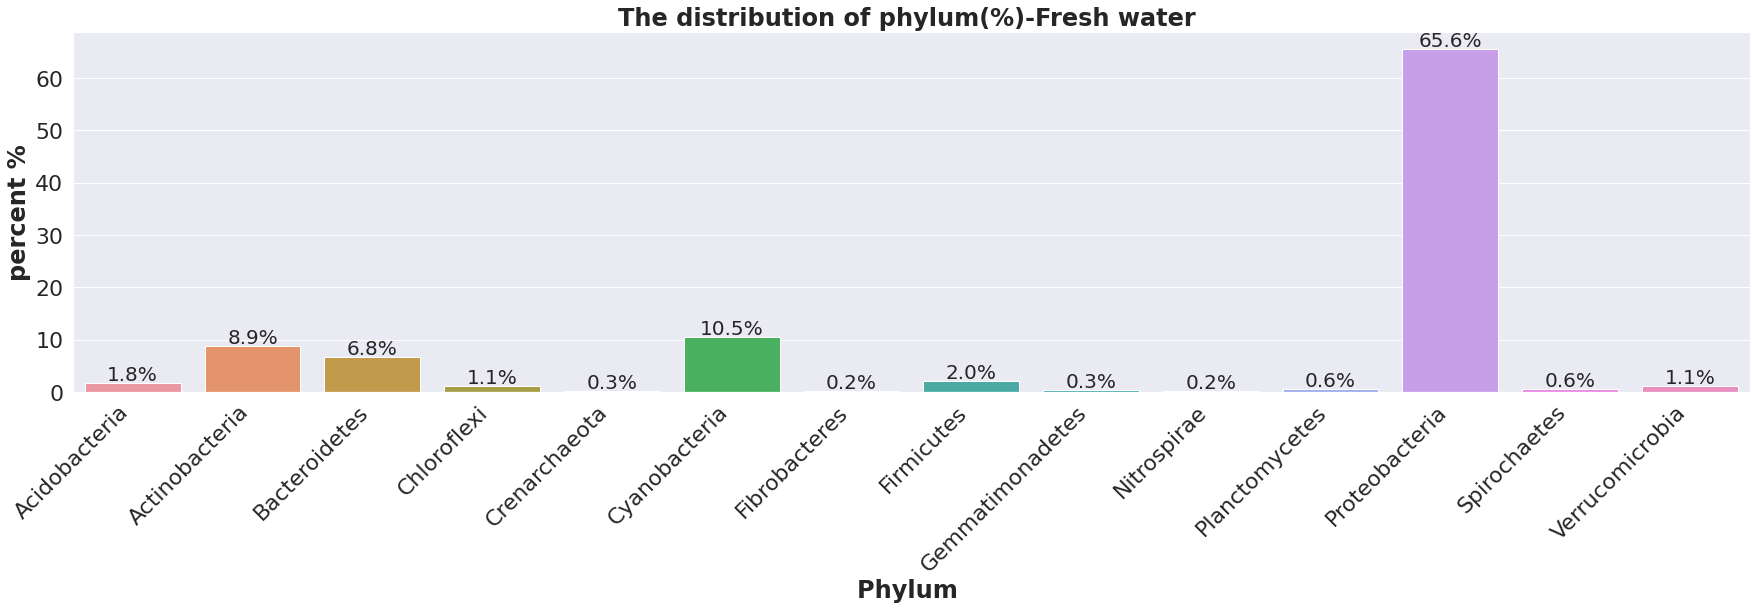

In [ ]:
#Sample SS1 by phylum in %
total_size = df_SS1_sum_size_by_phylum["size"].sum()
# print(total_size_ss1)
sns.set(font_scale = 2)
df_SS1_sum_size_by_phylum["%"]=(df_SS1_sum_size_by_phylum["size"]/total_size)*100
bp = sns.barplot(x= df_SS1_sum_size_by_phylum["phylum"], y= df_SS1_sum_size_by_phylum["%"])
plt.title('The distribution of phylum(%)-Fresh water ', weight='bold')
plt.xticks( rotation = 45, ha = 'right')

for bar in bp.patches:
    position = (bar.get_x() + bar.get_width() / 2, bar.get_height())
    text = f'{bar.get_height():.1f}'+"%"
    bp.annotate(s=text, xy=position, ha='center', va='center',
                      size=20, xytext=(0, 8), textcoords='offset points')
plt.ylabel("percent %", weight='bold')
plt.xlabel("Phylum ", weight='bold')
plt.tight_layout()
plt.show()

plt.rcParams["figure.figsize"] = (25, 9)


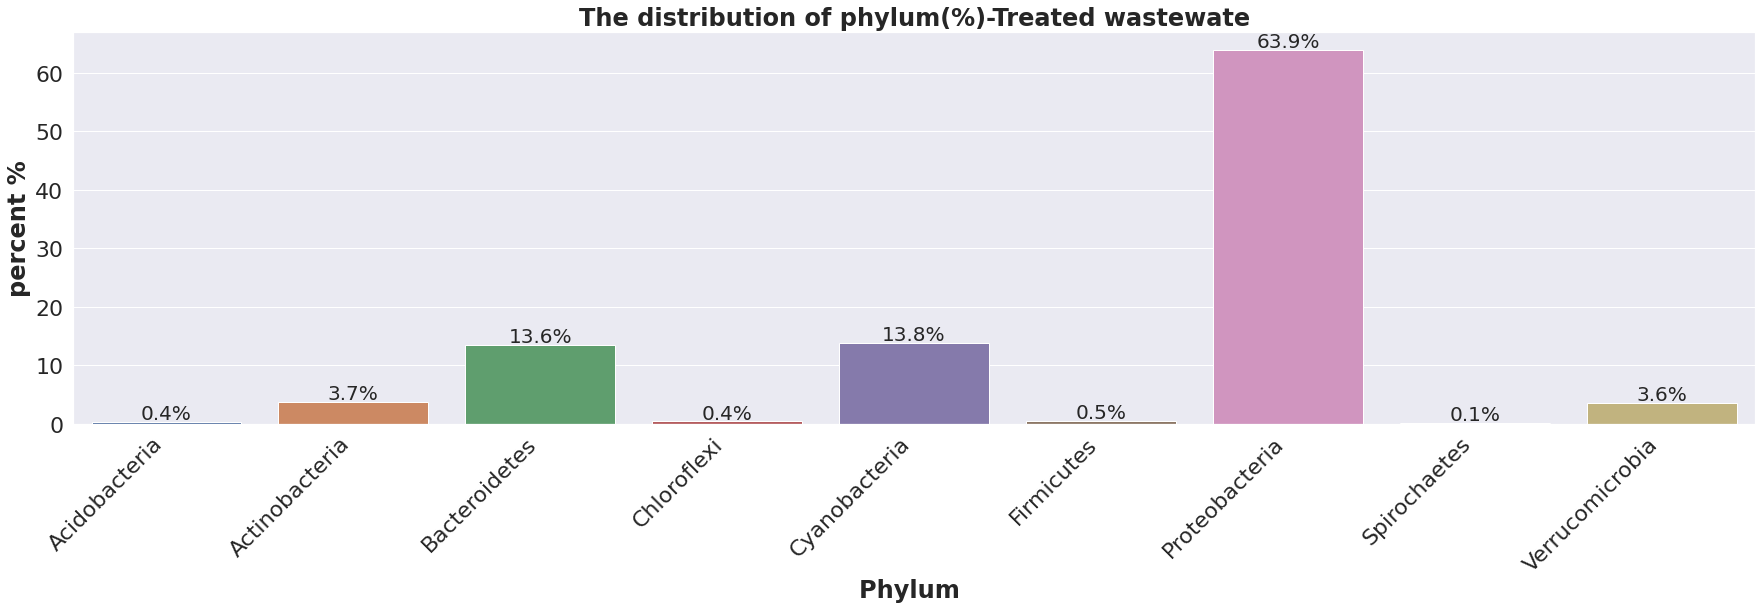

In [ ]:
#Sample SS2 by phylum in%
total_size_ss2 = df_SS2_sum_size_by_phylum["size"].sum()
sns.set(font_scale = 2)
df_SS2_sum_size_by_phylum["%"]=(df_SS2_sum_size_by_phylum["size"]/total_size_ss2)*100
bp = sns.barplot(x=df_SS2_sum_size_by_phylum["phylum"], y= df_SS2_sum_size_by_phylum["%"])
plt.title('The distribution of phylum(%)-Treated wastewate', weight='bold')
plt.xticks( rotation = 45, ha = 'right')

for bar in bp.patches:
    position = (bar.get_x() + bar.get_width() / 2, bar.get_height())
    text = f'{bar.get_height():.1f}'+"%"
    bp.annotate(s=text, xy=position, ha='center', va='center',
                      size=20, xytext=(0, 8), textcoords='offset points')

                     
plt.ylabel("percent %", weight='bold')
plt.xlabel("Phylum ", weight='bold')
plt.tight_layout()
plt.show()

plt.rcParams["figure.figsize"] = (25, 9)

8494


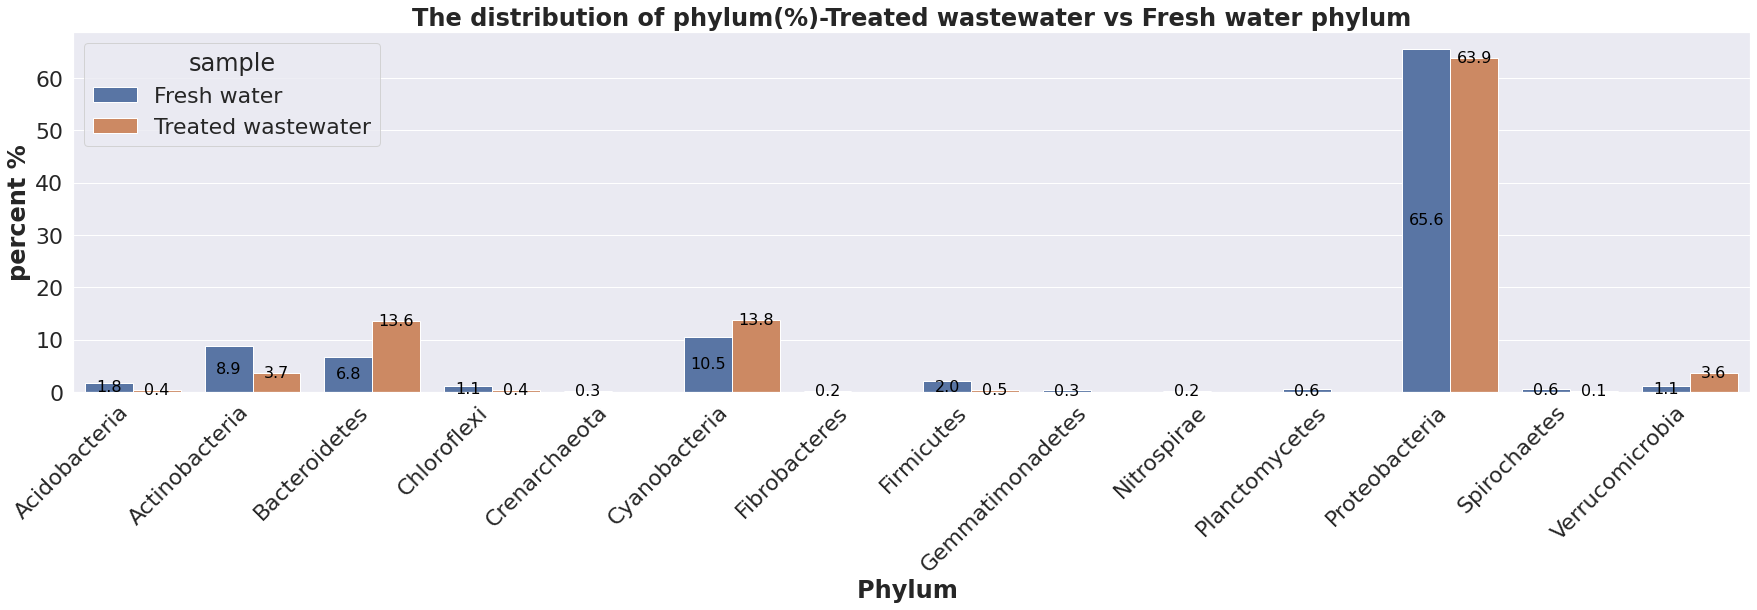

In [ ]:
#Treated wastewater vs Fresh water phylum in %

total_size_ss2 = df_SS2_sum_size_by_phylum["size"].sum()
print(total_size_ss2 )
df_SS2_sum_size_by_phylum["%"]=(df_SS2_sum_size_by_phylum["size"]/total_size_ss2)*100
df_SS2_sum_size_by_phylum["sample"]="Treated wastewater"
total_size_ss1 = df_SS1_sum_size_by_phylum["size"].sum()
df_SS1_sum_size_by_phylum["%"]=(df_SS1_sum_size_by_phylum["size"]/total_size_ss1)*100
df_SS1_sum_size_by_phylum["sample"]="Fresh water"
df=pd.concat([df_SS1_sum_size_by_phylum, df_SS2_sum_size_by_phylum], ignore_index=True)
#print(df)
plt.title('The distribution of phylum(%)-Treated wastewater vs Fresh water phylum', weight='bold')
plt.xticks( rotation = 45, ha = 'right')
bp=sns.barplot(x='phylum', y='%', hue='sample', data=df)

colors = list(set([bar.get_facecolor() for bar in bp.patches]))
locations = {
    colors[0]: False,
    colors[1]: True
    # Map colors to locations: False is below bar, True is above
}

for bar in bp.patches:
    height = bar.get_height()
    if math.isnan(height):
      continue

    location = locations[bar.get_facecolor()]
    if location:
      bp.text(bar.get_x() + bar.get_width() / 2., height, f"{height:.1f}",
                  ha='center', va='center', color='black', size=16)
    else:
      bp.text(bar.get_x() + bar.get_width() / 2., 0.5 * height, f"{height:.1f}",
                  ha='center', va='center', color='black', size=16)


plt.ylabel("percent %", weight='bold')
plt.xlabel("Phylum ", weight='bold')
plt.tight_layout()
plt.show()

plt.rcParams["figure.figsize"] = (25, 9)

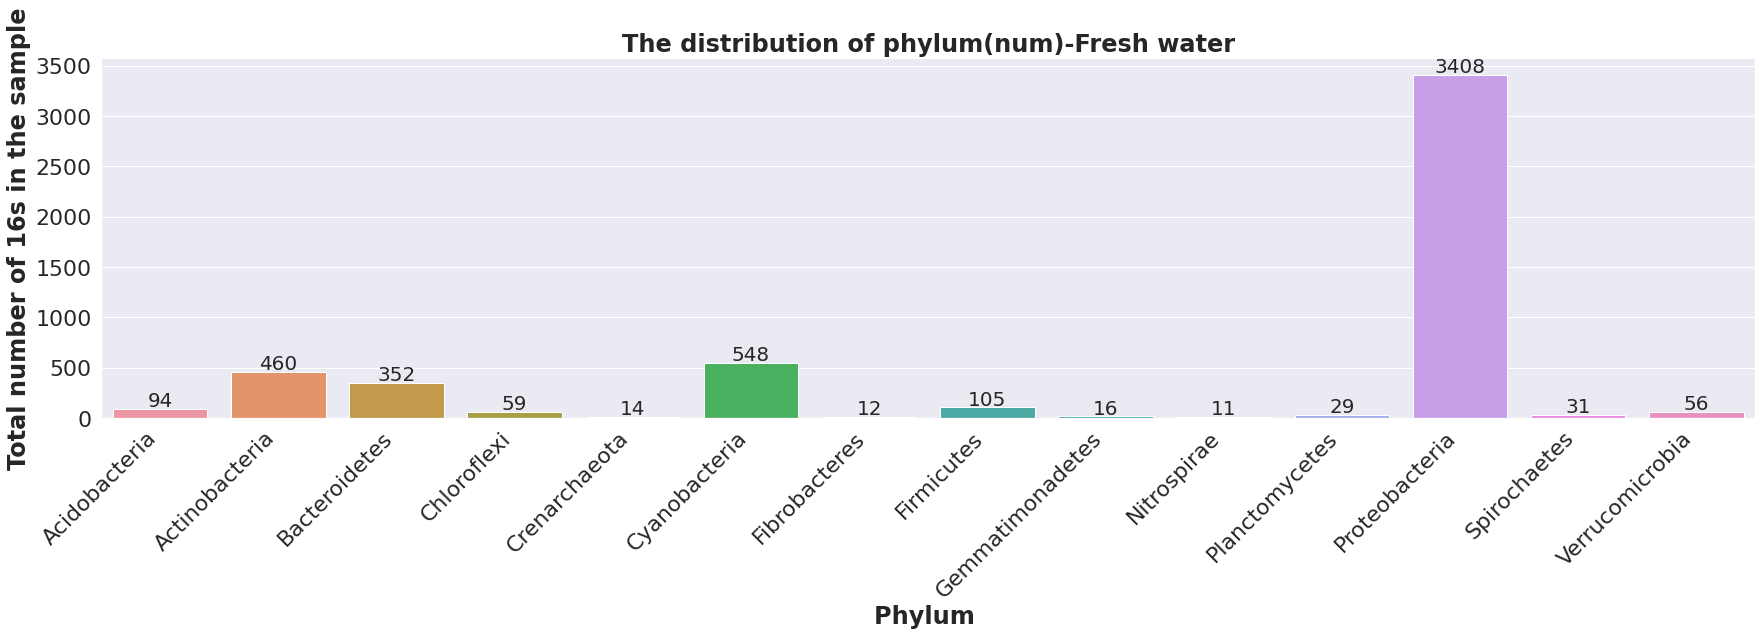

In [ ]:
#Sample SS1 by phylum - number of 16s in the sample

sns.set(font_scale = 2)

bp = sns.barplot(x=df_SS1_sum_size_by_phylum["phylum"], y= df_SS1_sum_size_by_phylum["size"])
plt.title('The distribution of phylum(num)-Fresh water', weight='bold')
plt.xticks( rotation = 45, ha = 'right')

for bar in bp.patches:
    position = (bar.get_x() + bar.get_width() / 2, bar.get_height())
    text = f'{bar.get_height():.0f}'
    bp.annotate(s=text, xy=position, ha='center', va='center',
                      size=20, xytext=(0, 8), textcoords='offset points')
plt.ylabel("Total number of 16s in the sample", weight='bold')
plt.xlabel("Phylum ", weight='bold')
plt.tight_layout()
plt.show()

plt.rcParams["figure.figsize"] = (25, 9)

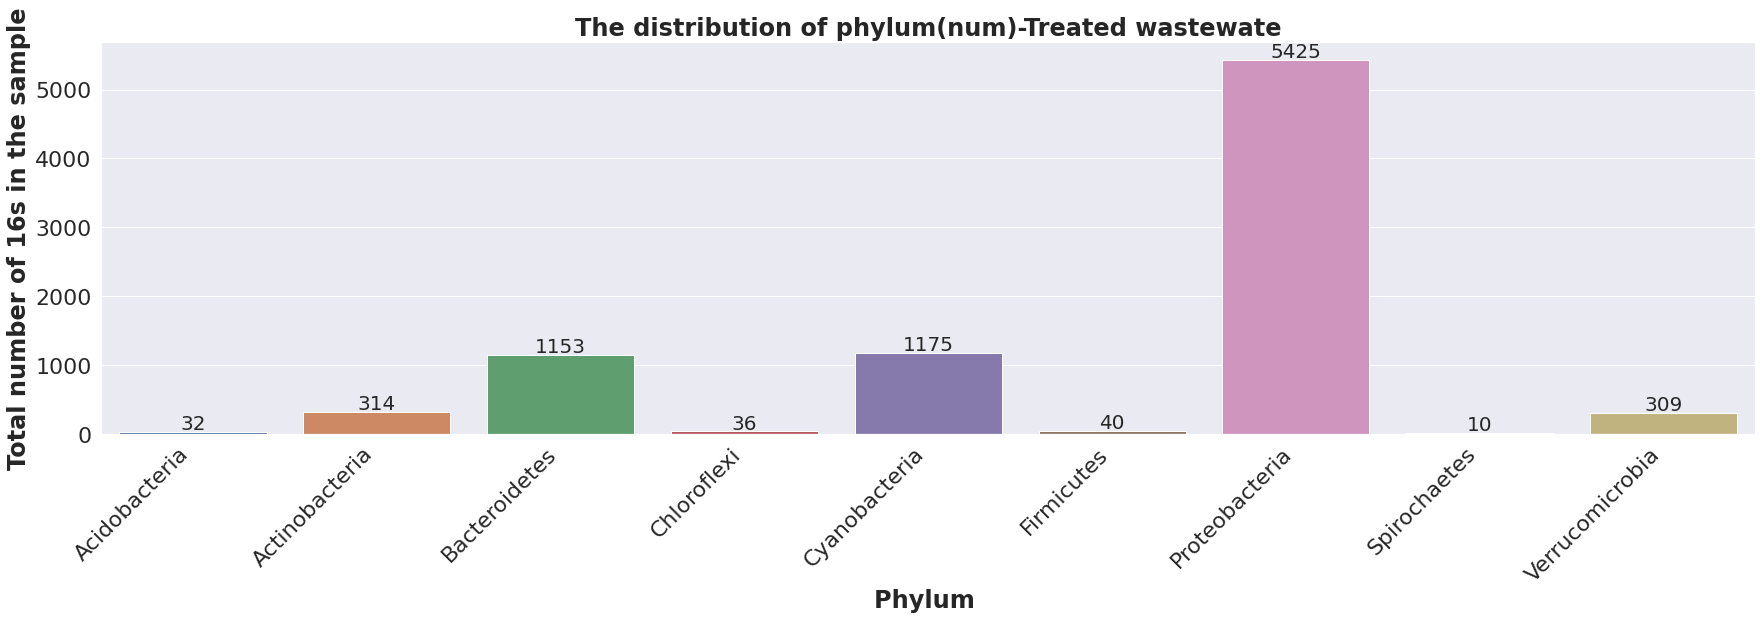

In [ ]:
#Sample SS2 by phylum - number of 16s in the sample

sns.set(font_scale = 2)

bp = sns.barplot(x=df_SS2_sum_size_by_phylum["phylum"], y= df_SS2_sum_size_by_phylum["size"])
plt.title('The distribution of phylum(num)-Treated wastewate', weight='bold')
plt.xticks( rotation = 45, ha = 'right')

for bar in bp.patches:
    position = (bar.get_x() + bar.get_width() / 2, bar.get_height())
    text = f'{bar.get_height():.0f}'
    bp.annotate(s=text, xy=position, ha='center', va='center',
                      size=20, xytext=(0, 8), textcoords='offset points')
plt.ylabel("Total number of 16s in the sample", weight='bold')
plt.xlabel("Phylum ", weight='bold')
plt.tight_layout()
plt.show()

plt.rcParams["figure.figsize"] = (25, 9)

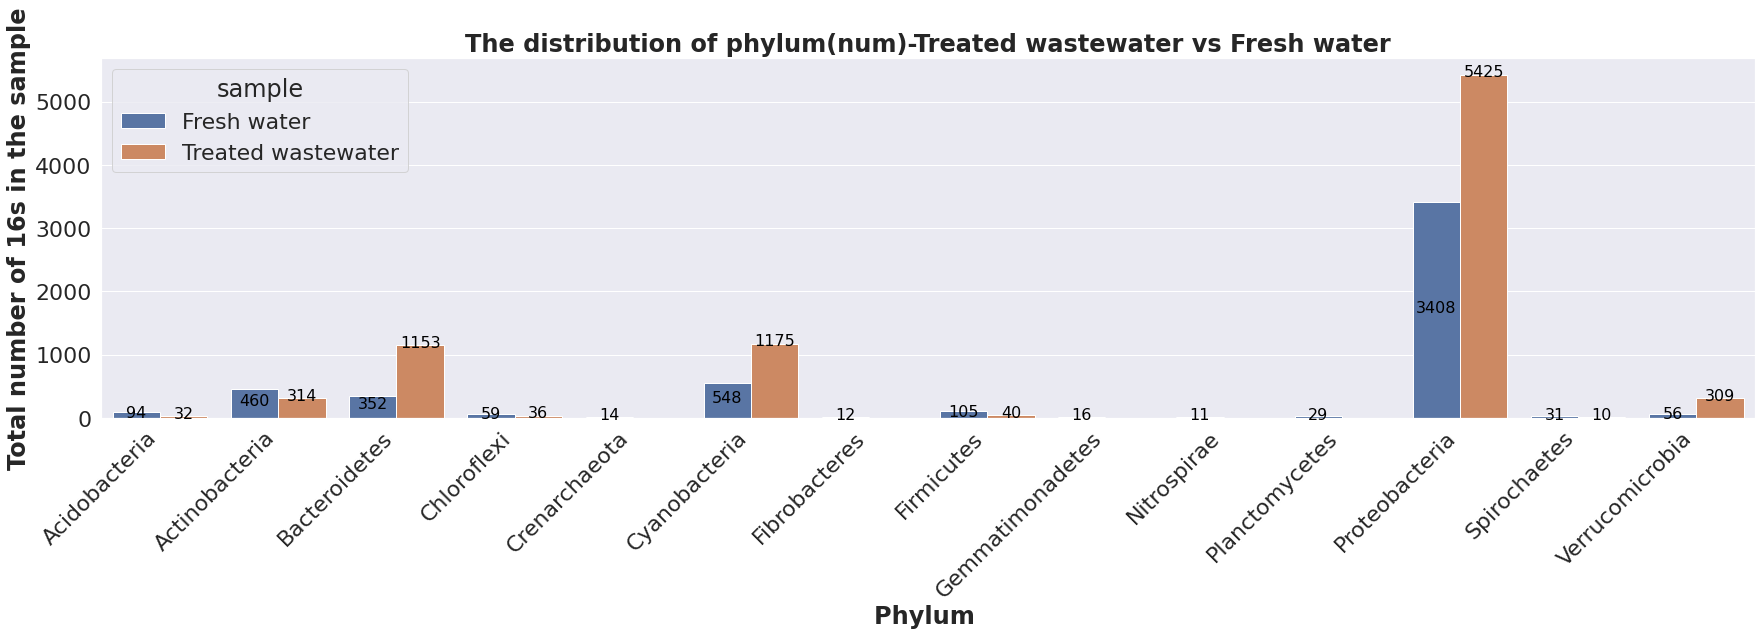

In [ ]:
#Treated wastewater vs Fresh water phylum - number of 16s in the sample


df_SS2_sum_size_by_phylum["sample"]="Treated wastewater"
df_SS1_sum_size_by_phylum["sample"]="Fresh water"
df=pd.concat([df_SS1_sum_size_by_phylum, df_SS2_sum_size_by_phylum], ignore_index=True)
#print(df)
plt.title('The distribution of phylum(num)-Treated wastewater vs Fresh water', weight='bold')
plt.xticks( rotation = 45, ha = 'right')
bp=sns.barplot(x='phylum', y='size', hue='sample', data=df)

colors = list(set([bar.get_facecolor() for bar in bp.patches]))
locations = {
    colors[0]: False,
    colors[1]: True
    # Map colors to locations: False is below bar, True is above
}

for bar in bp.patches:
    height = bar.get_height()
    if math.isnan(height):
      continue

    location = locations[bar.get_facecolor()]
    if location:
      bp.text(bar.get_x() + bar.get_width() / 2., height + 40, int(height),
                  ha='center', va='center', color='black', size=16)
    else:
      bp.text(bar.get_x() + bar.get_width() / 2., 0.5 * height + 40, int(height),
                  ha='center', va='center', color='black', size=16)


plt.ylabel("Total number of 16s in the sample", weight='bold')
plt.xlabel("Phylum ", weight='bold')
plt.tight_layout()
plt.show()

plt.rcParams["figure.figsize"] = (25, 9)

### Class

5195


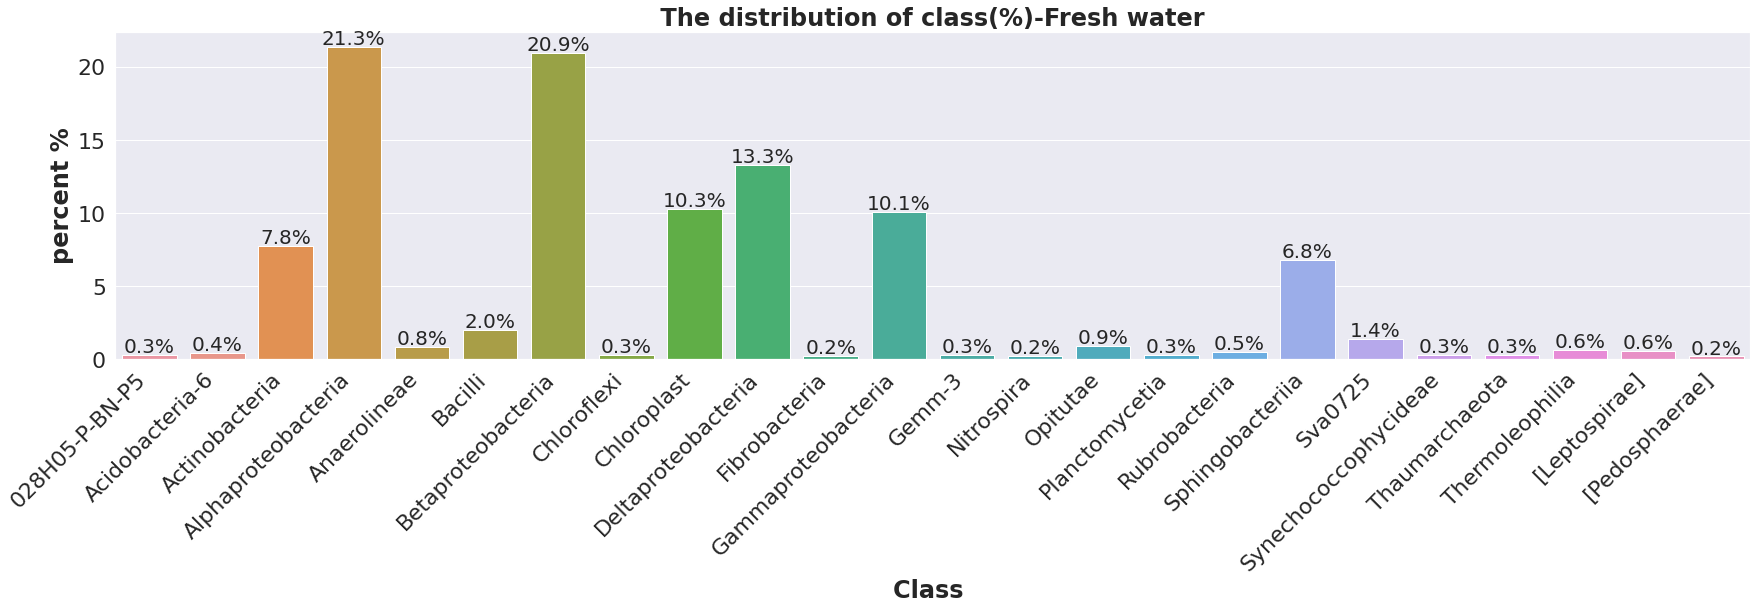

In [ ]:
#Sample SS1 by class in %
total_size = df_SS1_sum_size_by_class["size"].sum()
print(total_size_ss1)
sns.set(font_scale = 2)
df_SS1_sum_size_by_class["%"]=(df_SS1_sum_size_by_class["size"]/total_size)*100
bp = sns.barplot(x= df_SS1_sum_size_by_class["class"], y= df_SS1_sum_size_by_class["%"])
plt.title(' The distribution of class(%)-Fresh water ', weight='bold')
plt.xticks( rotation = 45, ha = 'right')

for bar in bp.patches:
    position = (bar.get_x() + bar.get_width() / 2, bar.get_height())
    text = f'{bar.get_height():.1f}'+"%"
    bp.annotate(s=text, xy=position, ha='center', va='center',
                      size=20, xytext=(0, 8), textcoords='offset points')
plt.ylabel("percent %", weight='bold')
plt.xlabel("Class ", weight='bold')
plt.tight_layout()
plt.show()

plt.rcParams["figure.figsize"] = (25, 9)

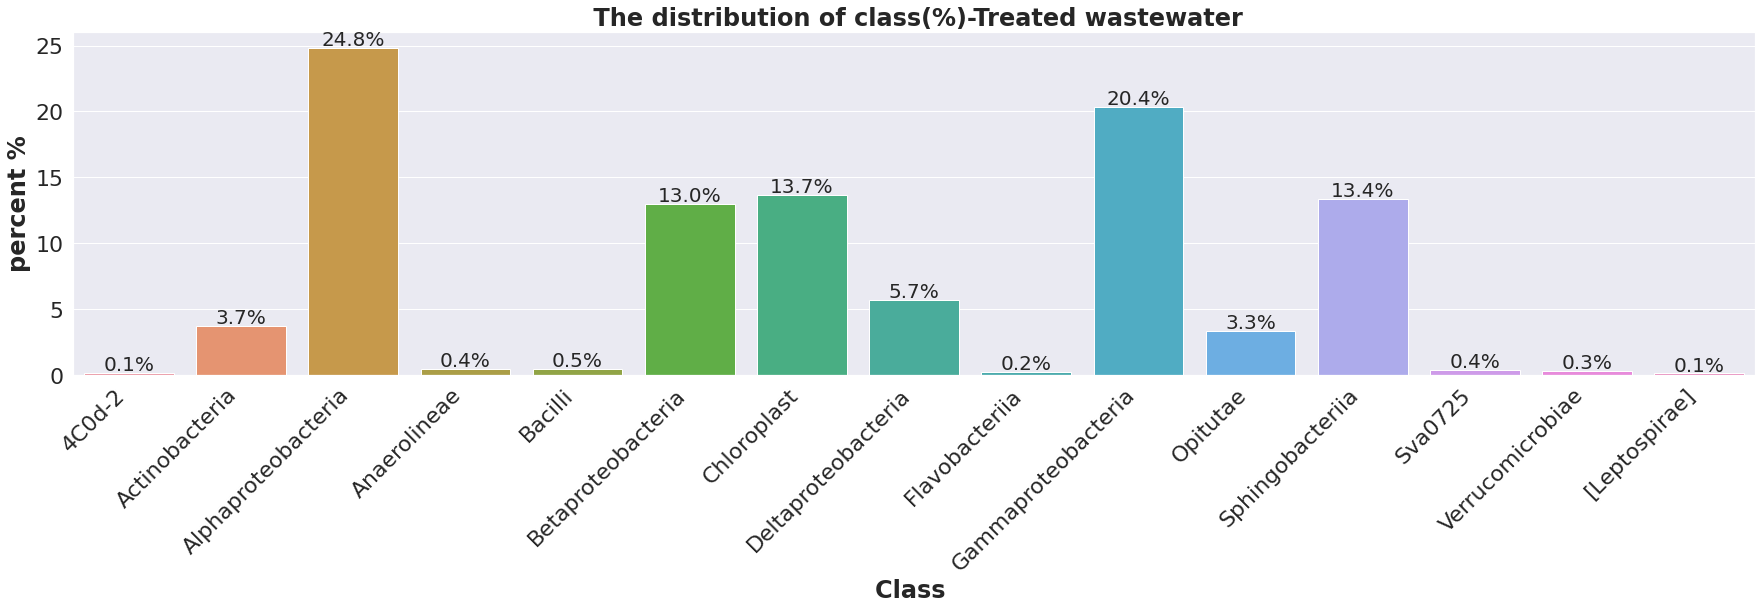

In [ ]:
#Sample SS2 by class in%
total_size_ss2 = df_SS2_sum_size_by_class["size"].sum()
sns.set(font_scale = 2)
df_SS2_sum_size_by_class["%"]=(df_SS2_sum_size_by_class["size"]/total_size_ss2)*100
bp = sns.barplot(x=df_SS2_sum_size_by_class["class"], y= df_SS2_sum_size_by_class["%"])
plt.title(' The distribution of class(%)-Treated wastewater', weight='bold')
plt.xticks( rotation = 45, ha = 'right')

for bar in bp.patches:
    position = (bar.get_x() + bar.get_width() / 2, bar.get_height())
    text = f'{bar.get_height():.1f}'+"%"
    bp.annotate(s=text, xy=position, ha='center', va='center',
                      size=20, xytext=(0, 8), textcoords='offset points')

                     
plt.ylabel("percent %", weight='bold')
plt.xlabel("Class ", weight='bold')
plt.tight_layout()
plt.show()

plt.rcParams["figure.figsize"] = (25, 9)

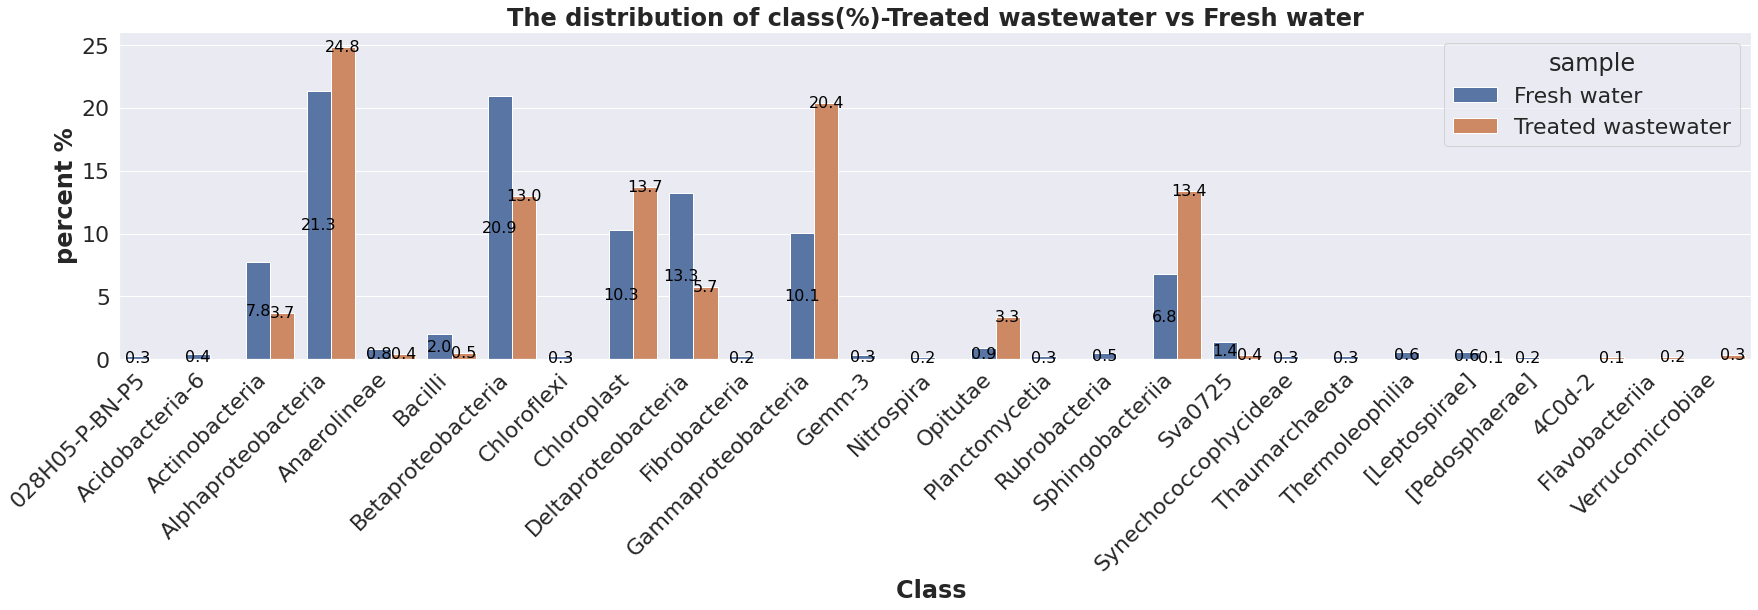

In [ ]:
#Treated wastewater vs Fresh water class in %

total_size_ss2 = df_SS2_sum_size_by_class["size"].sum()
df_SS2_sum_size_by_class["%"]=(df_SS2_sum_size_by_class["size"]/total_size_ss2)*100
df_SS2_sum_size_by_class["sample"]="Treated wastewater"
total_size_ss1 = df_SS1_sum_size_by_class["size"].sum()
df_SS1_sum_size_by_class["%"]=(df_SS1_sum_size_by_class["size"]/total_size_ss1)*100
df_SS1_sum_size_by_class["sample"]="Fresh water"
df=pd.concat([df_SS1_sum_size_by_class, df_SS2_sum_size_by_class], ignore_index=True)
#print(df)
plt.title('The distribution of class(%)-Treated wastewater vs Fresh water', weight='bold')
plt.xticks( rotation = 45, ha = 'right')
bp=sns.barplot(x='class', y='%', hue='sample', data=df)

colors = list(set([bar.get_facecolor() for bar in bp.patches]))
locations = {
    colors[0]: False,
    colors[1]: True
    # Map colors to locations: False is below bar, True is above
}

for bar in bp.patches:
    height = bar.get_height()
    if math.isnan(height):
      continue

    location = locations[bar.get_facecolor()]
    if location:
      bp.text(bar.get_x() + bar.get_width() / 2., height, f"{height:.1f}",
                  ha='center', va='center', color='black', size=16)
    else:
      bp.text(bar.get_x() + bar.get_width() / 2., 0.5 * height, f"{height:.1f}",
                  ha='center', va='center', color='black', size=16)


plt.ylabel("percent %", weight='bold')
plt.xlabel("Class ", weight='bold')
plt.tight_layout()
plt.show()

plt.rcParams["figure.figsize"] = (25, 9)

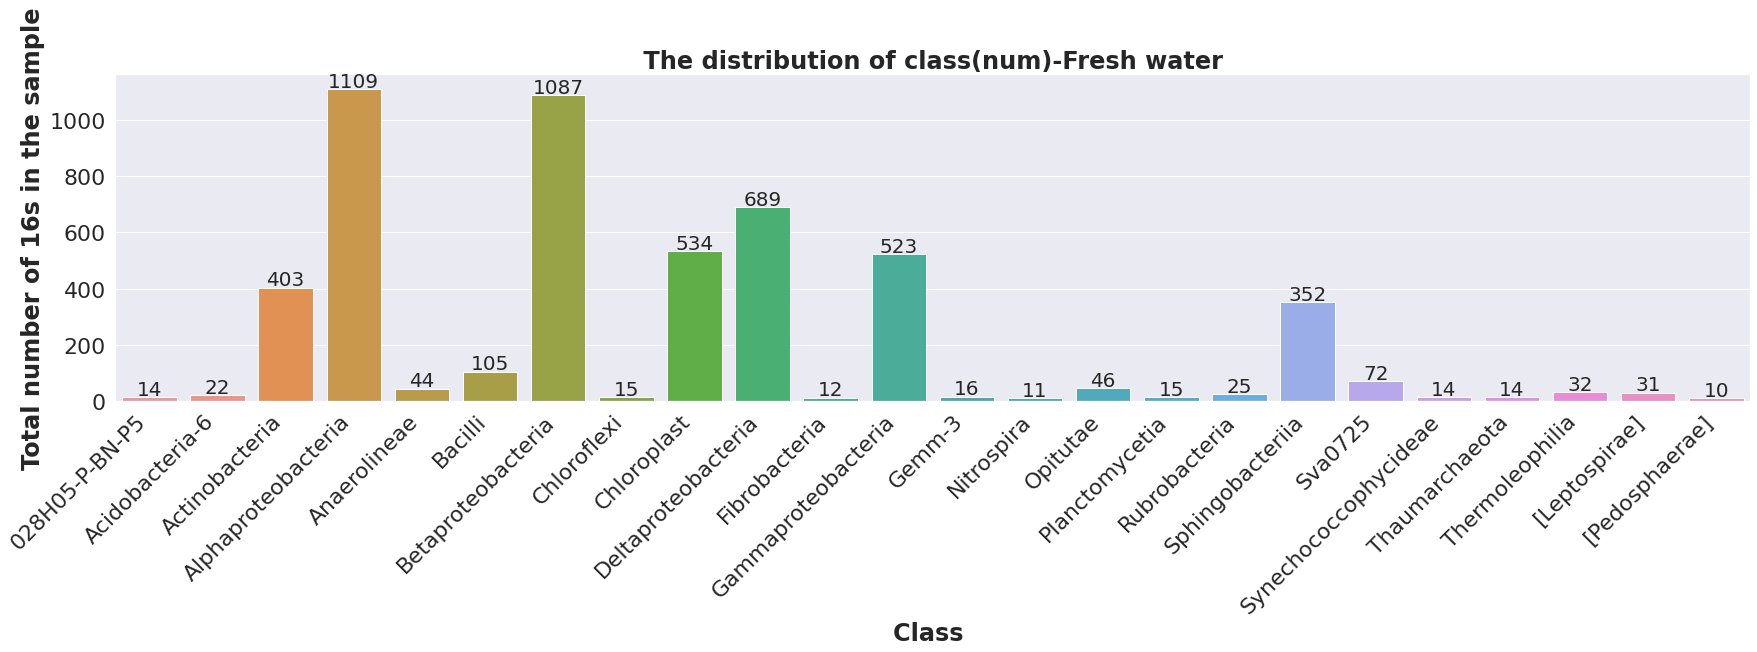

In [ ]:
#Sample SS1 by class- number of 16s in the sample

sns.set(font_scale = 2)

bp = sns.barplot(x=df_SS1_sum_size_by_class["class"], y= df_SS1_sum_size_by_class["size"])
plt.title(' The distribution of class(num)-Fresh water ', weight='bold')
plt.xticks( rotation = 45, ha = 'right')

for bar in bp.patches:
    position = (bar.get_x() + bar.get_width() / 2, bar.get_height())
    text = f'{bar.get_height():.0f}'
    bp.annotate(s=text, xy=position, ha='center', va='center',
                      size=20, xytext=(0, 8), textcoords='offset points')
plt.ylabel("Total number of 16s in the sample", weight='bold')
plt.xlabel("Class ", weight='bold')
plt.tight_layout()
plt.show()

plt.rcParams["figure.figsize"] = (25, 9)

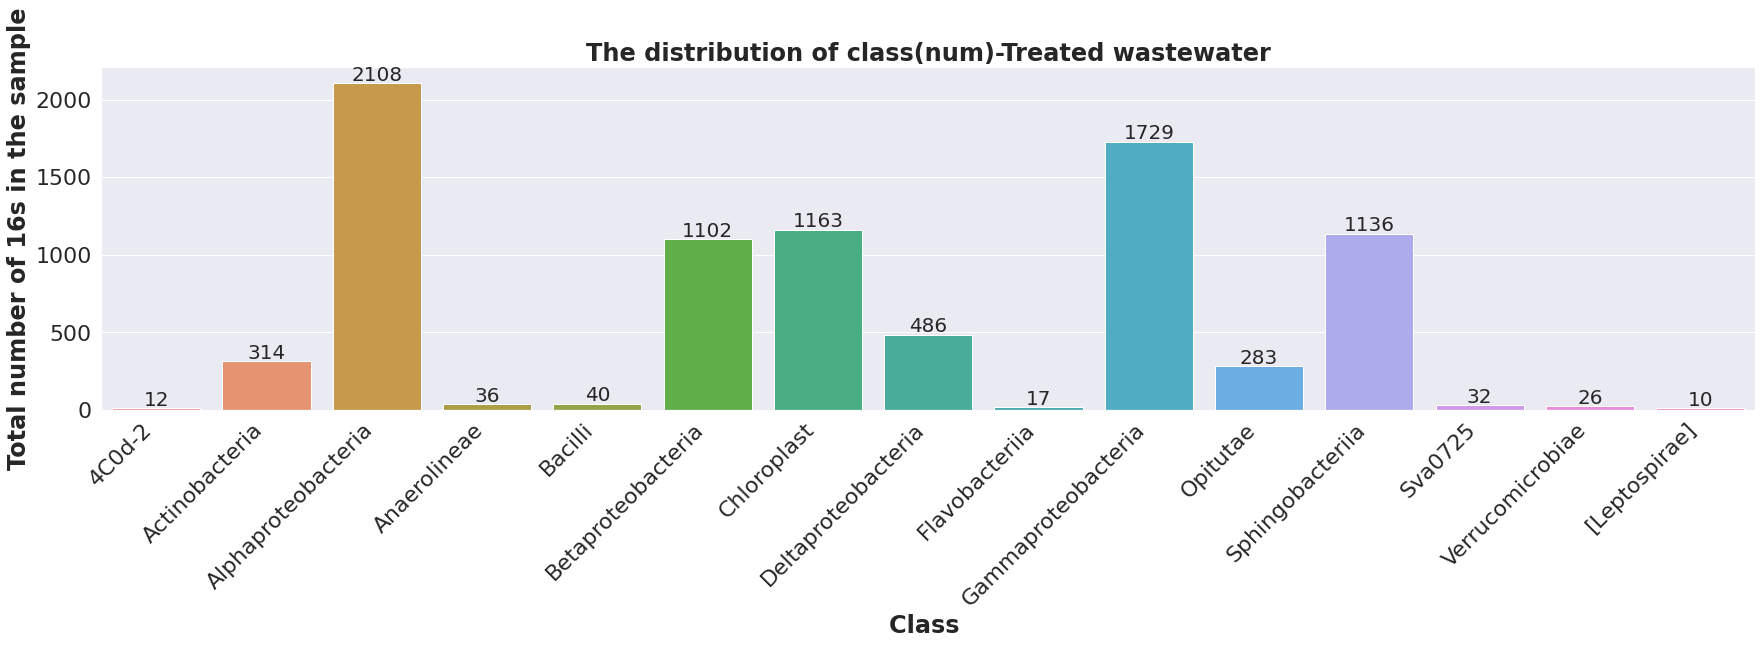

In [ ]:

#Sample SS2 by class - number of 16s in the sample

sns.set(font_scale = 2)

bp = sns.barplot(x=df_SS2_sum_size_by_class["class"], y= df_SS2_sum_size_by_class["size"])
plt.title('The distribution of class(num)-Treated wastewater', weight='bold')
plt.xticks( rotation = 45, ha = 'right')

for bar in bp.patches:
    position = (bar.get_x() + bar.get_width() / 2, bar.get_height())
    text = f'{bar.get_height():.0f}'
    bp.annotate(s=text, xy=position, ha='center', va='center',
                      size=20, xytext=(0, 8), textcoords='offset points')
plt.ylabel("Total number of 16s in the sample", weight='bold')
plt.xlabel("Class ", weight='bold')
plt.tight_layout()
plt.show()

plt.rcParams["figure.figsize"] = (25, 9)

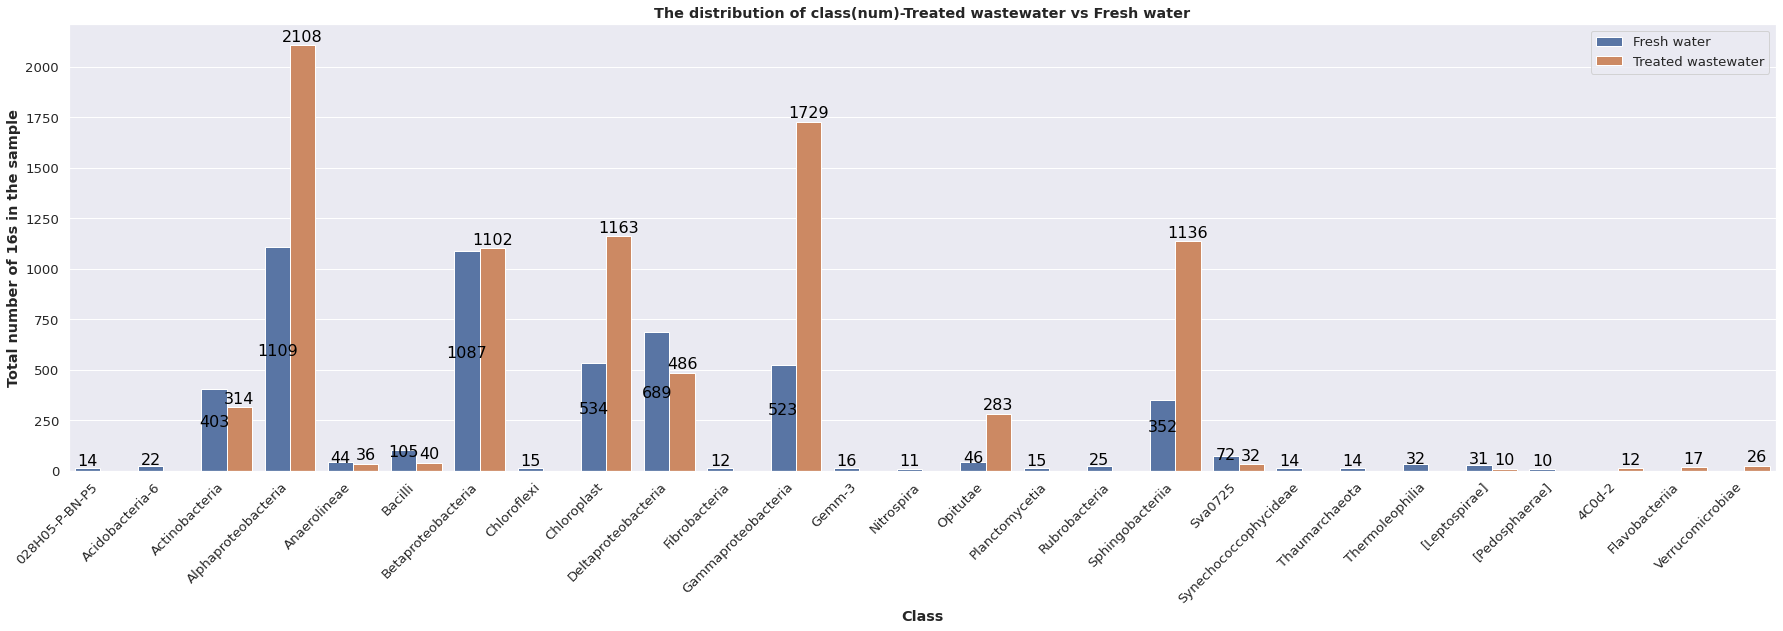

In [ ]:
#Treated wastewater vs Fresh water class - number of 16s in the sample

sns.set(font_scale = 1.2)
df_SS2_sum_size_by_class["sample"]="Treated wastewater"
df_SS1_sum_size_by_class["sample"]="Fresh water"
df_class_number=pd.concat([df_SS1_sum_size_by_class, df_SS2_sum_size_by_class], ignore_index=True)
#print(df)
plt.title('The distribution of class(num)-Treated wastewater vs Fresh water', weight='bold')
plt.xticks( rotation = 45, ha = 'right')
bp=sns.barplot(x='class', y='size', hue='sample', data=df_class_number)

colors = list(set([bar.get_facecolor() for bar in bp.patches]))
locations = {
    colors[0]: False,
    colors[1]: True
    # Map colors to locations: False is below bar, True is above
}

for bar in bp.patches:
    height = bar.get_height()
    if math.isnan(height):
      continue

    location = locations[bar.get_facecolor()]
    if location:
      bp.text(bar.get_x() + bar.get_width() / 2., height + 40, int(height),
                  ha='center', va='center', color='black', size=16)
    else:
      bp.text(bar.get_x() + bar.get_width() / 2., 0.5 * height + 40, int(height),
                  ha='center', va='center', color='black', size=16)

plt.ylabel("Total number of 16s in the sample", weight='bold')
plt.xlabel("Class", weight='bold')
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

plt.rcParams["figure.figsize"] = (20, 10)